In [2]:
import pandas
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np
import weightedstats
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

import vincent
import folium
from IPython.display import HTML
import pyproj
proj = pyproj.Proj(init="epsg:2263",preserve_units=True)
def inline_map(map):
    """
    Embeds the HTML source of the map directly into the IPython notebook.
    
    This method will not work if the map depends on any files (json data). Also this uses
    the HTML5 srcdoc attribute, which may not be supported in all browsers.
    """
    map._build_map()
    return HTML('<iframe srcdoc="{srcdoc}" style="width: 100%; height: 510px; border: none"></iframe>'.format(srcdoc=map.HTML.replace('"', '&quot;')))


In [3]:
mp = pandas.read_csv('MN.csv')
kp = pandas.read_csv('BK.csv')
xp = pandas.read_csv('BX.csv')
qp = pandas.read_csv('QN.csv')
sp = pandas.read_csv('SI.csv')
pluto = pandas.concat([mp,kp,xp,qp,sp],ignore_index=True)

/usr/local/lib/python2.7/dist-packages/pandas/io/parsers.py:1159: DtypeWarning: Columns (16,19,20,21,78) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)
/usr/local/lib/python2.7/dist-packages/pandas/io/parsers.py:1159: DtypeWarning: Columns (15,16,18,19,21,62,63) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)
/usr/local/lib/python2.7/dist-packages/pandas/io/parsers.py:1159: DtypeWarning: Columns (15,16,18,19,62,63,78) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)
/usr/local/lib/python2.7/dist-packages/pandas/io/parsers.py:1159: DtypeWarning: Columns (15,16,18,19,62,63,75,78) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)
/usr/local/lib/python2.7/dist-packages/pandas/io/parsers.py:1159: DtypeWarning: Columns (15,16,18,19,20,62,63,78) have mixed ty

#Reading PLUTO
For this exercise we only need a few columns:

In [4]:
pluto = pluto[['BoroCode','Block','Lot','OfficeArea','NumFloors','XCoord','YCoord']]
pluto = pluto[pluto['XCoord']>0]

Reading and cleaning 2014 rolling sales data (up to Nov 14):

In [5]:
def strip(text):
    try:
        return str(text).strip()
    except AttributeError:
        return str(text)
    
stripper = {'BUILDING CLASS CATEGORY' : strip, 'BUILDING CLASS CATEGORY\n' : strip, 'ADDRESS' : strip,
             'ADDRESS\n' :strip, 'APARTMENT NUMBER' : strip, 'APARTMENT NUMBER\n' : strip}

m2014 = pandas.read_excel(io='/home/ms142/nyproperty/rollingsales_manhattan.xls',skiprows=3,header=1,converters=stripper)
k2014 = pandas.read_excel(io='/home/ms142/nyproperty/rollingsales_brooklyn.xls',skiprows=3,header=1,converters=stripper)
q2014 = pandas.read_excel(io='/home/ms142/nyproperty/rollingsales_queens.xls',skiprows=3,header=1,converters=stripper)
x2014 = pandas.read_excel(io='/home/ms142/nyproperty/rollingsales_bronx.xls',skiprows=3,header=1,converters=stripper)
s2014 = pandas.read_excel(io='/home/ms142/nyproperty/rollingsales_statenisland.xls',skiprows=3,header=1,converters=stripper)
df14 = pandas.concat([m2014,k2014,q2014,x2014,s2014],ignore_index=True)

In [6]:
df14['year']=pandas.DatetimeIndex(df14['SALE DATE']).year
df14['month']=pandas.DatetimeIndex(df14['SALE DATE']).month
df14['NEIGHBORHOOD'] = df14['NEIGHBORHOOD'].apply(lambda x : x.strip())
df14=df14[(df14['SALE PRICE']>1e4) & (df14['SALE PRICE']<1.5e7)]
df14['TAX CLASS AT PRESENT']=df14['TAX CLASS AT PRESENT'].apply(str)
df14 = df14[df14['year']==2014]

#Joining the two datasets
Distribution of residential sales with more than six floors and total Office Area sold: 

In [7]:
df14 = pandas.merge(left=df14,right=pluto,how='left',
                    left_on=['BOROUGH','BLOCK','LOT'],right_on=['BoroCode','Block','Lot'])
df14.drop(['BoroCode','Block','Lot'],axis=1,inplace=True)
res_cond = df14['TAX CLASS AT PRESENT'].str.startswith('1',na=False) |  df14['TAX CLASS AT PRESENT'].str.startswith('2',na=False)

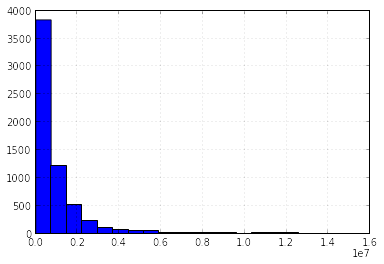

In [9]:
df14[res_cond & (df14['NumFloors']>6)]['SALE PRICE'].hist(bins=20)

In [11]:
df14['OfficeArea'].sum()

12057666.0

#Plotting residential sales by neighborhood

Folium doesn't support clickable geojson polygons, zoom-level dependent actions or hovering text - some javascript work directly on top of leaflet.js would be required - but it still presents all the information needed if we don't need the prettiest and slickest experience. 

In [20]:
res = df14[res_cond][['NEIGHBORHOOD','ZIP CODE','BOROUGH','BLOCK','LOT','SALE PRICE','year','month','XCoord','YCoord']]

In [21]:
def geolookup(row): #Convert State Plane coordinates to Lat/Long
    return list(proj(row['XCoord'],row['YCoord'],inverse=True))[::-1]

res['lat long'] = res.apply(geolookup,axis=1)

In [22]:
zip_median = res.groupby('ZIP CODE')['SALE PRICE'].median()

In [23]:
zip_monthly = res.groupby(['ZIP CODE','month'])['SALE PRICE'].sum()

In [49]:
#File source = http://pablotron.org/files/zipcodes-csv-10-Aug-2004.zip 
global geozc
geozc=pandas.read_csv('zipcode.csv',index_col=0,header=0)

In [122]:
# Converts median price to color
def scale_to_hex(val):
    val = val/2e6
    cscale=plt.get_cmap('YlOrRd')
    rgb = cscale(val)[0:3]
    rgb = tuple(np.round(255*x) for x in rgb)
    hex = "#%02x%02x%02x" % rgb
    return hex

# Plots all the sales locations in the zip code and refocus the map
def fill_zip_code(zc,my_map):
    my_map.template_vars['zoom_level']=14
    my_map.template_vars['lat']=geozc.loc[zc].latitude
    my_map.template_vars['lon']=geozc.loc[zc].longitude
    for ll in res[res['ZIP CODE']==zc]['lat long']:
        if ((ll[0]>45) | (ll[1]>-70)):
            continue
        my_map.circle_marker(location=ll, radius=10, line_color=None, popup='',
                            fill_color='purple',fill_opacity=0.5)
    return inline_map(my_map)

In [123]:
location=[40.70,-73.90]
mymap = folium.Map(location=location,tiles='Stamen Toner',zoom_start=11)
for zc in res['ZIP CODE'].unique():
    if zc in geozc.index:
        line = vincent.Line(zip_monthly[zc])
        line.width = 400
        line.height = 200
        line.padding = {'top': 5, 'left': 80, 'bottom': 40, 'right': 10}
        line.axis_titles(x='2014 Monthly $ (Zip code = '+str(zc)+', 2014 Median = $'+str(zip_median[zc])+')',y='')
        line.to_json('sales_'+str(zc)+'.json')
        scaled_color = scale_to_hex(zip_median[zc])
        mymap.circle_marker(location=[geozc.loc[zc].latitude, geozc.loc[zc].longitude], radius=400,
                        popup=(line,'sales_'+str(zc)+'.json'),line_color=None,
                        fill_color=scaled_color,fill_opacity=0.4)

inline_map(mymap)

Filling out all the properties sold as little circles would make the rendering too slow, so this function fills one zip code at a time and zooms to it: 

In [124]:
fill_zip_code(10028,mymap)